# Assignment 4

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [4]:
G1 = pickle.load(open("assets/A4_P1_G1", "rb"))
G2 = pickle.load(open("assets/A4_P1_G2", "rb"))
G3 = pickle.load(open("assets/A4_P1_G3", "rb"))
G4 = pickle.load(open("assets/A4_P1_G4", "rb"))
G5 = pickle.load(open("assets/A4_P1_G5", "rb"))

P1_Graphs = [G1, G2, G3, G4, G5]

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs using any methodology and determine which of the three algorithms generated each graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

In [26]:
def graph_identification():
    # define a list of strings corresponding to the algorithm
    algorithms = []
    for G in P1_Graphs:
        clustering = nx.average_clustering(G)
        shortest_path = nx.average_shortest_path_length(G)
        degrees = dict(G.degree())
        degree_hist = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in sorted(set(degrees.values()))]
        
        # use degree distribution to identify Preferential Attachment,
        # because it has a long tail in the degree distribution
        # which means the clustering coefficient is low
        if len(degree_hist)>10:
            algorithms.append('PA')
        else:
            # low probability of rewiring causes 
            # a longer average shortest path length and a higher clustering coefficient
            if shortest_path >= 10:
                algorithms.append('SW_L')
            # high probability of rewiring causes
            # a shorter average shortest path length and a lower clustering coefficient
            else:
                algorithms.append('SW_H')
    return algorithms

graph_identification()

['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

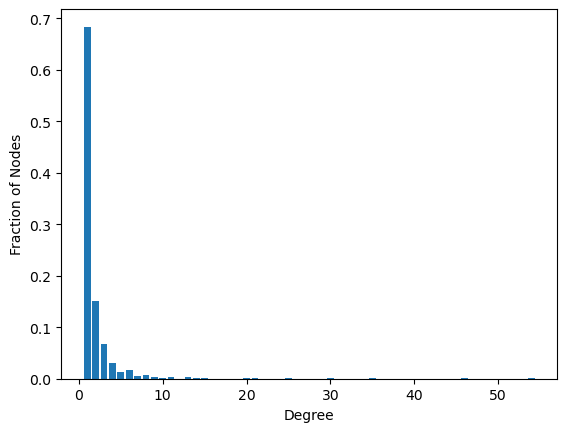

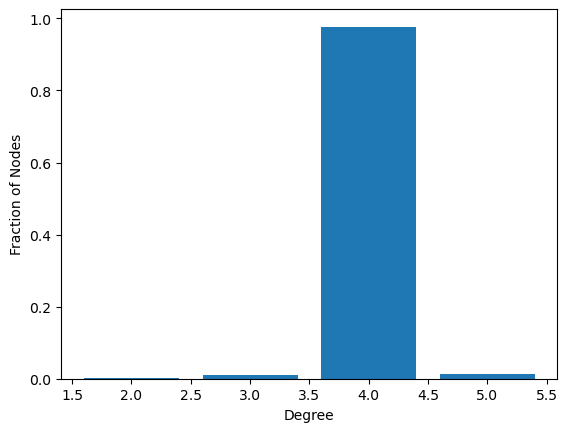

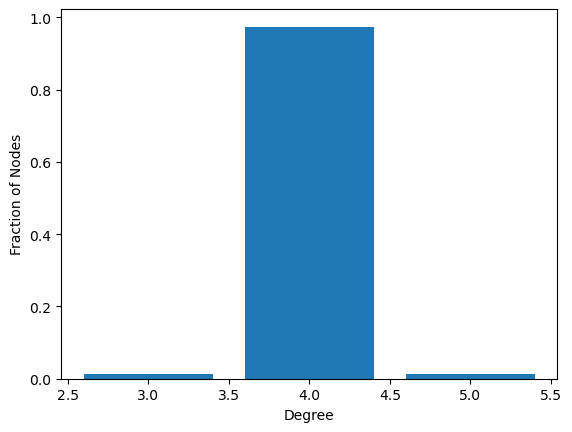

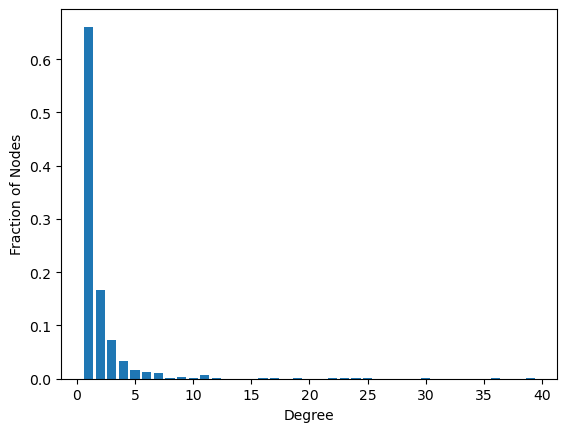

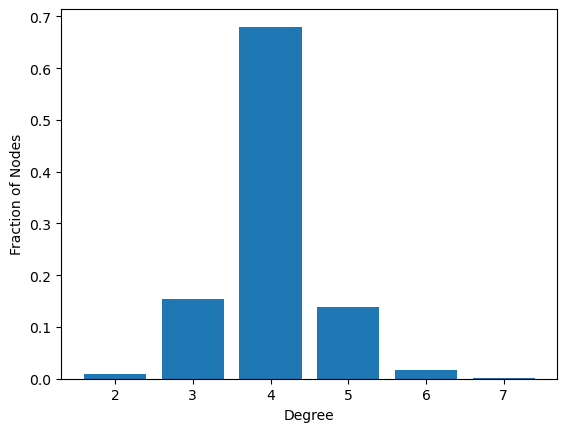

In [15]:
# Visulaize five graphs to identify the type of graph
import matplotlib.pyplot as plt
for G in P1_Graphs:
    # get all degrees
    degrees = dict(G.degree())
    # get all degree values
    degree_values = sorted(set(degrees.values()))
    # create histogram of degree distribution in proportion to all nodes
    histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]
    plt.bar(degree_values, histogram)
    plt.xlabel('Degree')
    plt.ylabel('Fraction of Nodes')
    plt.show()

In [ ]:
ans_one = graph_identification()
assert type(ans_one) == list, "You must return a list"


---

## Part 2 - Company Emails

For the second part of this assignment you will be working with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagmentSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagmentSalary` indicates whether that person is receiving a managment position salary.

In [24]:
G = pickle.load(open('assets/email_prediction_NEW.txt', 'rb'))

print(f"Graph with {len(nx.nodes(G))} nodes and {len(nx.edges(G))} edges")

Graph with 1005 nodes and 16706 edges


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a managment position salary.

To accomplish this, you will need to create a matrix of node features of your choice using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a managment salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a managment position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.75 or higher will recieve full points.

Using your trained classifier, return a Pandas series of length 252 with the data being the probability of receiving managment salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [31]:
list(G.nodes(data=True))[:5] # print the first 5 nodes

[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (581, {'Department': 3, 'ManagementSalary': 0.0}),
 (6, {'Department': 25, 'ManagementSalary': 1.0}),
 (65, {'Department': 4, 'ManagementSalary': nan})]

In [27]:
def salary_predictions():
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    
    # create a dataframe with the node attributes
    df = pd.DataFrame(index=G.nodes())
    df['ManagementSalary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
    df['Department'] = pd.Series(nx.get_node_attributes(G, 'Department'))
    df['Clustering'] = pd.Series(nx.clustering(G))
    df['DegreeCentrality'] = pd.Series(nx.degree_centrality(G))
    df['BetweennessCentrality'] = pd.Series(nx.betweenness_centrality(G))
    df['ClosenessCentrality'] = pd.Series(nx.closeness_centrality(G))
    df['PageRank'] = pd.Series(nx.pagerank(G))
    df['Hub'], df['Authority'] = pd.Series(nx.hits(G))
    
    # Separate the data into train and test sets
    X, y = df.iloc[:, 1:], df.iloc[:, 0]
    X_train, y_train = X.loc[~np.isnan(y), :], y[~np.isnan(y)]
    X_test, y_test = X.loc[np.isnan(y), :], y[np.isnan(y)]
    
    # use random forest classifier to predict the probability of the node
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    
    # return a series of the AUC score of the management salary being true
    predict_proba = pd.Series(rf.predict_proba(X_test)[:, 1], index=X_test.index)
    return predict_proba

salary_predictions()

1      0.08
65     0.96
18     0.03
215    0.92
283    1.00
       ... 
691    0.00
788    0.00
944    0.00
798    0.00
808    0.00
Length: 252, dtype: float64

In [28]:
ans_salary_preds = salary_predictions()
assert type(ans_salary_preds) == pd.core.series.Series, "You must return a Pandas series"
assert len(ans_salary_preds) == 252, "The series must be of length 252"


### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [29]:
future_connections = pd.read_csv('assets/Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to:      
1. Create a matrix of features of your choice for the edges found in `future_connections` using Networkx     
2. Train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data     
3. Predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.75 or higher will recieve full points.

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [30]:
def new_connections_predictions():
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.ensemble import RandomForestClassifier

    df = future_connections.copy()
    H = G.copy()
    
    # a dictionary comprehension is used to create a dictionary from the `data` list.
    # The keys of the dictionary are tuples `(x, y)`, and the values are the `z` elements.
    # This dictionary is then converted into a pandas Series
    index_to_Series = lambda data: pd.Series({(x, y): z for x, y, z in data})
    
    # Add the features of nodes
    # Add the number of common neighbors between each pair of nodes that are not connected
    df['Common Neighbors'] = index_to_Series([(e[0], e[1], len(list(nx.common_neighbors(G, e[0], e[1])))) for e in nx.non_edges(H)])
    df['Jaccard Coefficient'] = index_to_Series(nx.jaccard_coefficient(H))
    df['Resource Allocation'] = index_to_Series(nx.resource_allocation_index(H))
    df['Preferential Attachment'] = index_to_Series(nx.preferential_attachment(H))
    
    # Add community as a node attribute
    for node in H.nodes():
        H.nodes[node]['community'] = H.nodes[node]['Department']
    # Add the features of nodes with community
    df['Community Common Neighbors'] = index_to_Series(nx.cn_soundarajan_hopcroft(H))
    df['Community Resource Allocation'] = index_to_Series(nx.ra_index_soundarajan_hopcroft(H))
    
    # Separate the data into train and test sets
    # based on the missing values of the 'future_connections'
    X, y = df.iloc[:, 1:], df.iloc[:, 0]
    X_train, y_train = X.loc[~np.isnan(y), :], y[~np.isnan(y)]
    X_test, y_test = X.loc[np.isnan(y), :], y[np.isnan(y)]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    predict_proba = pd.Series(rf.predict_proba(X_test)[:, 1], index=X_test.index)
    return predict_proba

new_connections_predictions()

(107, 348)    0.000000
(542, 751)    0.012737
(20, 426)     0.640000
(50, 989)     0.014090
(942, 986)    0.010812
                ...   
(165, 923)    0.015669
(673, 755)    0.009700
(939, 940)    0.010812
(555, 905)    0.020702
(75, 101)     0.000000
Length: 122112, dtype: float64

In [ ]:
ans_prob_preds = new_connections_predictions()
assert type(ans_prob_preds) == pd.core.series.Series, "You must return a Pandas series"
assert len(ans_prob_preds) == 122112, "The series must be of length 122112"
